In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tqdm import tqdm


In [2]:
plt.rcParams["figure.figsize"] = (10,5)


In [3]:
dataset= pd.read_csv("dataset.csv")
# drop the iron concetration column, as we are not allowed to use it
dataset.drop("% Iron Concentrate", axis=1, inplace=True)

dataset["date"] = pd.to_datetime(dataset['date'], format='%Y-%m-%d %H:%M:%S')

for col in dataset.columns[1:]:
    dataset[col] = dataset[col].apply(lambda x: x.replace(",", "."))
    dataset[col] = dataset[col].astype(float)

dataset


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,2017-03-10 01:00:00,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,...,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,1.31
1,2017-03-10 01:00:00,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,...,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,1.31
2,2017-03-10 01:00:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,...,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,1.31
3,2017-03-10 01:00:00,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,...,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,1.31
4,2017-03-10 01:00:00,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,...,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,2017-09-09 23:00:00,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,...,346.794,313.695,392.160,430.702,872.008,418.725,497.548,446.357,416.892,1.71
737449,2017-09-09 23:00:00,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,...,330.023,236.700,401.505,404.616,864.409,418.377,506.398,372.995,426.337,1.71
737450,2017-09-09 23:00:00,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,...,329.590,225.879,408.899,399.316,867.598,419.531,503.414,336.035,433.130,1.71
737451,2017-09-09 23:00:00,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,...,351.453,308.115,405.107,466.832,876.591,407.299,502.301,340.844,433.966,1.71


In [4]:
# check for missing values
print("Are there missing values?")
dataset.isna().values.any()


Are there missing values?


False

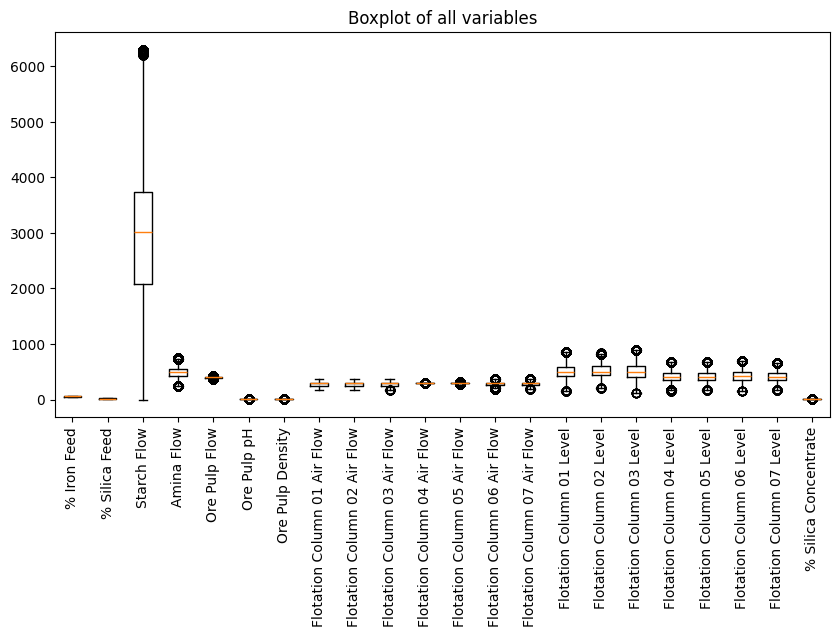

In [5]:
dataset_wo_date = dataset.drop("date", axis=1)

plt.title("Boxplot of all variables")
plt.boxplot(dataset_wo_date)
plt.xticks(range(1, len(dataset_wo_date.columns) + 1), dataset_wo_date.columns.to_list(), rotation=90)
plt.show()


# Resolving timestamp problems

In [6]:
EXPECTED_SAMPLE_COUNT = 180

# determine which timestamps are incomplete
def determine_incomplete_dates(df):
    last_date = df.date.iloc[0]
    current_count = 1
    invalid_counts = []
    for date in df.date.iloc[1:]:
        if last_date == date:
            current_count += 1
        else:
            if current_count != EXPECTED_SAMPLE_COUNT:
                invalid_counts.append((last_date, current_count))
            last_date = date
            current_count = 1

    if invalid_counts:
        print("Timestamps with missing values:")
        for timestamp, count in invalid_counts:
            print(f"{timestamp}: {count} samples")
    else:
        print("All dates have correct number of samples")

determine_incomplete_dates(dataset)


Timestamps with missing values:
2017-03-10 01:00:00: 174 samples
2017-04-10 00:00:00: 179 samples


In [7]:
# remove first 174 rows, as the measurement is incomplete
dataset.drop(index=dataset.index[:174], axis=0, inplace=True)

# duplicate the last row of the date with 179 measurements
line = dataset.loc[dataset.date == "2017-04-10 00:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])
dataset = pd.concat([dataset.iloc[:iloc], line, dataset.iloc[iloc:]]).reset_index(drop=True)


In [8]:
determine_incomplete_dates(dataset)


All dates have correct number of samples


Timedelta 3600.0: 4094x
Timedelta 1148400.0: 1x


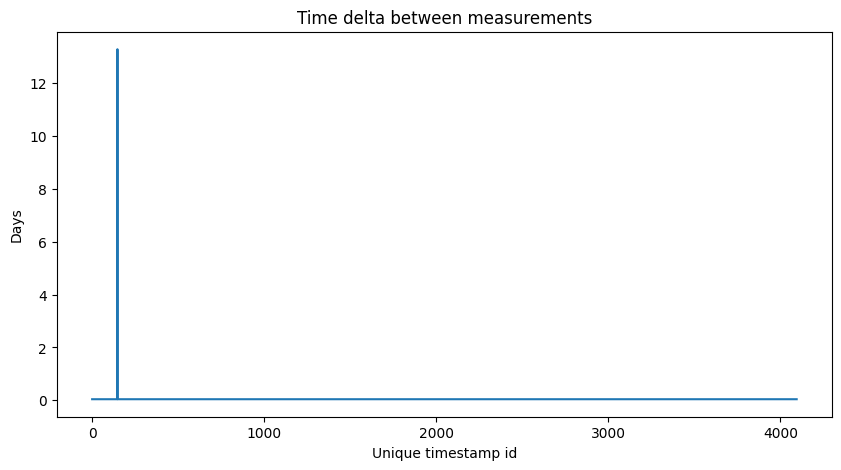

In [9]:
# check if timedelta is same throughout the dataset
def check_timedeltas(df):
    udates = df.date.unique()
    last = udates[0]
    timedeltas = []
    for date in udates[1:]:
        timedeltas.append((date-last) / np.timedelta64(1, 's'))
        last = date

    timedeltas = np.array(timedeltas)
    unique, counts = np.unique(timedeltas, return_counts=True)
    for value, count in zip(unique, counts):
        print(f"Timedelta {value}: {count}x")
    return timedeltas

timedeltas = check_timedeltas(dataset)
plt.title("Time delta between measurements")
plt.plot(timedeltas/60/60/24)
plt.xlabel("Unique timestamp id")
plt.ylabel("Days")
plt.show()


In [10]:
# find the gap
udates = dataset.date.unique()
last = udates[0]
for date in udates[1:]:
    if (date-last) / np.timedelta64(1, 's') != 3600.0:
        print(pd.to_datetime(last).strftime('%Y-%m-%d %H:%M:%S'))
    last = date
    

2017-03-16 05:00:00


In [11]:
line = dataset.loc[dataset.date == "2017-03-16 05:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])

dataset_small = dataset.iloc[:iloc+1]
dataset_big = dataset.iloc[iloc+1:]


In [12]:
_ = check_timedeltas(dataset_small)


Timedelta 3600.0: 147x


In [13]:
_ = check_timedeltas(dataset_big)


Timedelta 3600.0: 3947x


# Resampling

In [14]:
# determine which measurements were taken every hour
udate_count = len(udates)
skip_first = True
for name, values in dataset_big.items():
    if skip_first:
        skip_first = False
        continue

    count = len(values.unique())
    if count <= udate_count:
        print(f"Column \"{name}\" was probably sampled every hour")


Column "% Iron Feed" was probably sampled every hour
Column "% Silica Feed" was probably sampled every hour


In [15]:
dataset_big


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
26640,2017-03-29 12:00:00,60.18,9.34,2044.99,349.911,405.625,9.74604,1.649650,200.393,195.734,...,250.601,251.002,555.264467,552.255566,614.984714,428.430,413.662,447.887,464.869,1.36
26641,2017-03-29 12:00:00,60.18,9.34,2020.55,353.064,404.402,9.74169,1.643469,200.131,196.476,...,250.208,250.828,557.839933,554.531131,659.557429,431.146,422.308,444.326,463.224,1.36
26642,2017-03-29 12:00:00,60.18,9.34,2012.84,356.217,403.180,9.73733,1.637289,199.869,197.219,...,249.815,250.653,560.415400,556.806697,704.130143,433.863,430.954,440.765,461.579,1.36
26643,2017-03-29 12:00:00,60.18,9.34,2007.67,359.371,401.957,9.73298,1.631108,199.607,197.961,...,249.422,250.478,562.990867,559.082262,748.702857,436.580,439.600,437.204,459.935,1.36
26644,2017-03-29 12:00:00,60.18,9.34,2003.92,362.524,400.735,9.72862,1.624928,199.345,198.703,...,249.029,250.304,565.566333,561.357828,793.275571,439.296,448.246,433.643,458.290,1.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737275,2017-09-09 23:00:00,49.75,23.20,2710.94,441.052,386.570,9.62129,1.653650,302.344,298.786,...,346.794,313.695,392.160000,430.702000,872.008000,418.725,497.548,446.357,416.892,1.71
737276,2017-09-09 23:00:00,49.75,23.20,2692.01,473.436,384.939,9.62063,1.653520,303.013,301.879,...,330.023,236.700,401.505000,404.616000,864.409000,418.377,506.398,372.995,426.337,1.71
737277,2017-09-09 23:00:00,49.75,23.20,2692.20,500.488,383.496,9.61874,1.653380,303.662,307.397,...,329.590,225.879,408.899000,399.316000,867.598000,419.531,503.414,336.035,433.130,1.71
737278,2017-09-09 23:00:00,49.75,23.20,1164.12,491.548,384.976,9.61686,1.653240,302.550,301.959,...,351.453,308.115,405.107000,466.832000,876.591000,407.299,502.301,340.844,433.966,1.71


In [16]:
new_df = pd.DataFrame(columns=dataset_big.columns)
new_df


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate


In [17]:

for i, date in enumerate(dataset_big.date.unique()):
    new_df.loc[i] = dataset_big[dataset_big.date == date].mean()
    new_df.loc[i, "date"] = date
new_df


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,2017-03-29 12:00:00,60.18,9.34,1060.859297,379.836203,400.982539,9.527187,1.550374,200.035839,195.5777,...,250.069722,249.992956,753.724247,726.559437,860.557818,477.349197,452.512522,478.219647,470.105547,1.36
1,2017-03-29 13:00:00,60.18,9.34,2034.926525,322.233975,400.468947,9.700679,1.532017,199.990122,195.10625,...,250.029056,250.059711,848.675503,777.784437,869.419421,483.816131,469.448172,471.607075,462.665478,1.43
2,2017-03-29 14:00:00,60.18,9.34,1435.425811,474.656322,399.157083,9.687788,1.6452,200.019311,195.604928,...,249.979356,250.111328,851.951492,776.293654,879.704989,456.147231,453.227,447.708467,453.475667,1.33
3,2017-03-29 15:00:00,60.18,9.34,618.460387,396.377733,398.942522,9.851689,1.559929,199.940833,195.657094,...,249.978589,250.028506,855.91063,780.369869,882.093896,449.410744,448.581506,450.697578,448.660094,1.27
4,2017-03-29 16:00:00,59.54,9.56,1367.502858,317.134072,400.836283,9.936163,1.530984,199.878922,196.162864,...,250.061661,250.122067,851.603513,784.446084,884.840698,450.12305,451.774694,451.574422,449.406894,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,2017-09-09 19:00:00,49.75,23.2,3327.047776,497.211189,380.8472,9.176166,1.660871,301.565561,300.169133,...,335.658144,298.736661,397.781583,498.753311,403.858956,398.930467,502.971728,399.468911,400.559511,1.65
3944,2017-09-09 20:00:00,49.75,23.2,4225.800333,508.963856,381.112889,9.387541,1.691996,300.050172,299.967839,...,348.1728,303.599269,399.928567,499.64895,399.208611,399.967122,501.624533,398.905006,400.486233,1.71
3945,2017-09-09 21:00:00,49.75,23.2,2808.214692,517.748822,381.064411,9.771277,1.735647,299.814289,299.801561,...,349.422803,309.875439,399.961433,500.484917,471.827489,399.931033,500.223311,401.899806,400.556333,1.8
3946,2017-09-09 22:00:00,49.75,23.2,3191.497672,492.511228,380.445006,9.782121,1.716644,300.122756,299.679472,...,349.613589,305.254558,399.601383,498.614494,836.277192,400.455389,500.406239,402.703283,401.769072,1.96


In [18]:
dataset_big = new_df


In [19]:
# def resample(df: pd.DataFrame):
#     print("Resampling begin")
#     column_names = ["date", "% Iron Feed", "% Silica Feed"]
#     for i, column_name in enumerate(column_names):
#         print(f"Resampling column {i+1}/{len(column_names)}")
#         column = df[column_name]
#         column_iloc = dataset.columns.get_loc(column_name)
#         values = column.values

#         for i_batch in tqdm(range(0, column.size-EXPECTED_SAMPLE_COUNT, EXPECTED_SAMPLE_COUNT)):
#             range_from = values[i_batch]
#             range_to = values[i_batch+EXPECTED_SAMPLE_COUNT]
#             delta = (range_to - range_from) / EXPECTED_SAMPLE_COUNT
#             for i_item in range(EXPECTED_SAMPLE_COUNT):
#                 values[i_batch + i_item] = range_from + delta*i_item
#         df.iloc[:,column_iloc]
#     return df.copy()

# plt.title("Before resampling")
# plt.plot(dataset_small["date"])
# plt.show()

# dataset_small = resample(dataset_small)
# dataset_big = resample(dataset_big)

# # drop values that cannot be resampled
# dataset_small.drop(index=dataset_small.index[-180:], axis=0, inplace=True)
# dataset_big.drop(index=dataset_big.index[-180:], axis=0, inplace=True)

# plt.title("After resampling")
# plt.plot(dataset_small["date"])
# plt.show()


In [20]:
dataset_big.reset_index(drop=True, inplace=True)

dataset_small_wo_date = dataset_small.drop("date", axis=1)
dataset_big_wo_date = dataset_big.drop("date", axis=1)


# Establishing time lag optimality

In [21]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


dataset_big.loc[:,'date'] = pd.to_datetime(dataset_big['date'])

tss = TimeSeriesSplit(n_splits = 2)

dataset_big.set_index('date', inplace=True)
dataset_big.sort_index(inplace=True)
X = dataset_big.iloc[:,:-1]
train_y = dataset_big.iloc[:,-1:]

for train_index, test_index in tss.split(X):
    X_calib, X_valid = X.iloc[train_index, :], X.iloc[test_index,:]
    y_calib, y_valid = train_y.iloc[train_index], train_y.iloc[test_index]



#center and scaling 
scaler = StandardScaler()
scaler.fit(X_calib)

# Scale the calibration data
scaled_train = scaler.transform(X_calib)
calib_set = pd.DataFrame(scaled_train, columns=X_calib.columns)

#scaling the validation data 
scaled_valid = scaler.transform(X_valid)
valid_set = pd.DataFrame(scaled_valid, columns=X_valid.columns)

#scaling the testing data 
X_test = dataset_small_wo_date.iloc[:,:-1]
y_test = dataset_small_wo_date.iloc[:,-1:]
scaled_test = scaler.transform(X_test)
testing_set = pd.DataFrame(scaled_test, columns=X_test.columns)

#center and scale output column 
scalerY = StandardScaler()
scalerY.fit(y_calib)

scaled_y_calib = scalerY.transform(y_calib)
calib_y = pd.DataFrame(scaled_y_calib, columns=y_calib.columns)

scaled_y_valid = scalerY.transform(y_valid)
valid_y = pd.DataFrame(scaled_y_valid, columns=y_valid.columns)

scaled_y_test = scalerY.transform(y_test)
testing_y = pd.DataFrame(scaled_y_test, columns=y_test.columns)




In [42]:
import time_lag_optimizers as tlo
import importlib
importlib.reload(tlo)

UPPER_LAG_BOUND = 20 
STEP = 1


# cs = calib_set.copy()
# cs["y"] = calib_y
# shift(cs, 20, "y")
# cy = calib_y.tail(cs.shape[0]).copy()

# vs = valid_set.copy()
# vs["y"] = valid_y
# shift(vs, 20, "y")
# vy = valid_y.tail(vs.shape[0]).copy()
# determine_optimal_time_lag(cs, cy, cs, cy)
# optimizer = tlo.VerticalStairsOptimizer(STEP, UPPER_LAG_BOUND, "out/test")
optimizer = tlo.DynamicOptimizerOneAtATime(STEP, UPPER_LAG_BOUND, "out/test")
res = optimizer.run(calib_set, calib_y, valid_set, valid_y)
res



1.0440769597457515
1.036032845569303
1.0143308508443913
0.8759342179164236
0.8653745244636426
0.8415894420603914
0.83553621568998
0.821769545891574
0.821235152697652
0.8132609063976527
0.8128460468552193
0.8106319246395862
0.7917517794168527
0.7915919879843907
0.7904437262334332
0.7893783681722001
0.7887858573286518


array([3, 0, 0, 1, 4, 3, 0, 0])

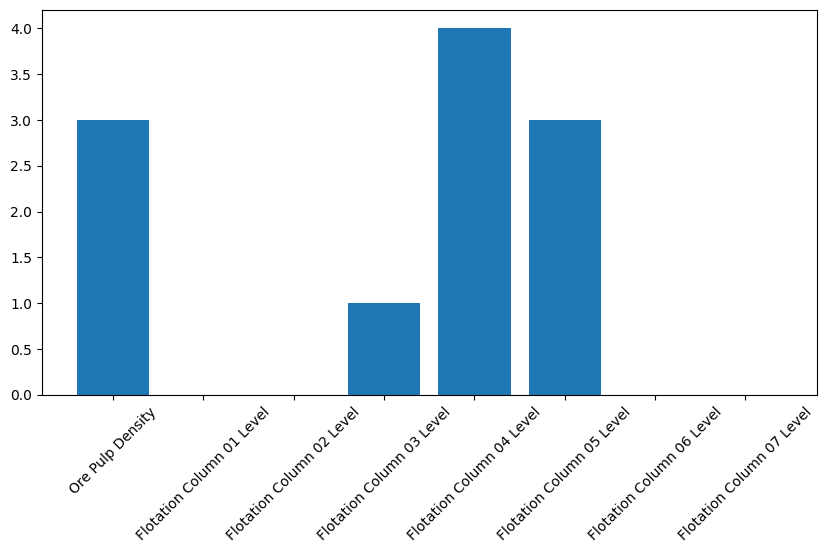

In [36]:
boundaries = [
    "% Iron Feed",
    "Ore Pulp Density",
    "Flotation Column 01 Level",
    "Flotation Column 02 Level",
    "Flotation Column 03 Level",
    "Flotation Column 04 Level",
    "Flotation Column 05 Level",
    "Flotation Column 06 Level",
    "Flotation Column 07 Level",
    # "y"
]

lags = [24,24,18,15,12,13,13,7]
lags = [3, 0, 0, 1, 4, 3, 0, 0] # mse 0.7887858573286518
plt.bar(range(len(lags)), lags)
plt.xticks(range(len(lags)), boundaries[1:], rotation=45)
plt.show()


In [ ]:
testdf = dataset.copy()

shift(testdf, 20, "Ore Pulp Density")
testdf


NameError: name 'shift' is not defined